# Iniciación en Python con Aplicaciones en Aceración (module 02)

**Dr. Edgar Ivan Castro Cedeño**

[edgar.castro@cinvestav.mx](mailto:edgar.castro@cinvestav.mx)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import src.desulf as desulf # funciones propias
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

In [24]:
random_state = 42

# 5. Análisis de datos de proceso

En este ejemplo práctico se muestra el proceso de evaluación del rendimiento de desulfuración en un proceso de refinación secundaria de acero, a partir de datos de producción sintéticos.

## 5.1 Generación de datos sintéticos

### 5.1.1 Parámetros de proceso

In [25]:
ks = 0.05 #  constante de desulfuración [min-1]
wS0 = 0.04 # azufre inicial [wt%]
Msl = 10 # masa de escoria [kg/ton]
Ls = 400 # coeficiente de reparto de azufre [-]
t_eval = np.linspace(0, 60, 121) # tiempo de proceso [min]

### 5.1.2 Generación de datos

In [26]:
# generador de numeros aleatorios
rng = np.random.default_rng(seed=random_state)

In [27]:
nHeats = 200 #  coladas muestreadas
nSamples = 4 # muestras por colada
std = 0.1 # # standard deviation for random normal noise
data = np.empty(shape=(nSamples*nHeats, 4))

for ii in range(nHeats):
    # ruido
    ks_n = rng.normal(ks, std*ks)
    wS0_n = rng.normal(wS0, std*wS0)
    Msl_n = rng.normal(Msl, std*Msl)
    Ls_n = rng.normal(Ls, std*Ls)
    #ks_n = np.random.normal(0, std*ks)
    #wS0_n = np.random.normal(0, std*wS0)
    #Msl_n = np.random.normal(0, std*Msl)
    #Ls_n = np.random.normal(0, std*Ls)

    # solución de la ecuación
    sol = solve_ivp(
        fun = desulf.desulfRate,
        t_span = (t_eval[0], t_eval[-1]),
        y0 = [wS0_n],
        args = (ks_n, wS0_n, Msl_n, Ls_n),
        t_eval = t_eval
    )

    # toma de muestras (tiempos semi-aleatorios)
    for samp in range(nSamples):
        ind0 = samp * len(t_eval) // nSamples
        tind = min(ind0+np.random.randint(0, 25), len(t_eval)) #desface
        data[nSamples*ii+samp,:] = [ii, samp, sol.t[tind], np.round(sol.y[0][tind], 4)]

# Guardar datos en DataFrame
df = pd.DataFrame(data=data, columns=["heat", "sample", "t", "S"])
df = df.astype({"heat": "int32", "sample": "int32"})
display(df)


,heat,sample,t,S
0,0,0,4.5,0.0286
1,0,1,16.0,0.0172
2,0,2,35.5,0.0095
3,0,3,47.5,0.0078
4,1,0,0.5,0.0341
...,...,...,...,...
795,198,3,45.5,0.0112
796,199,0,5.0,0.0339
797,199,1,26.5,0.0142
798,199,2,34.5,0.0117


In [28]:
df['S'].max()

np.float64(0.0425)

## 5.2 Análisis de datos de proceso

### 5.2.1 Visualización de datos crudos

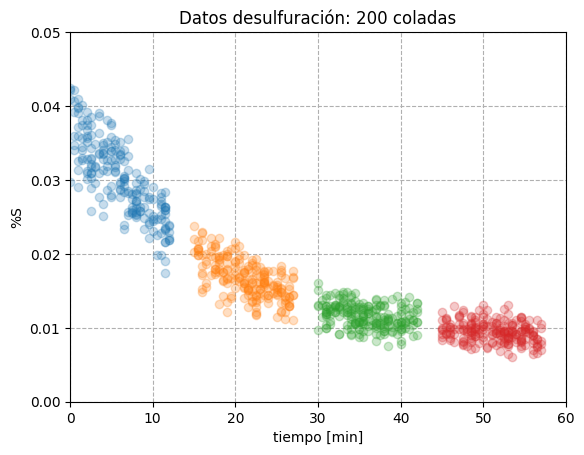

In [29]:
# visualización de los datos de proceso
fig, ax = plt.subplots()

unique_samples = pd.unique(df["sample"])
for sample in (unique_samples):
    dfr = df[df["sample"] == sample]
    ax.plot(dfr["t"], dfr["S"], ls='', marker='o', alpha=0.25)
ax.set(
    xlabel='tiempo [min]',
    ylabel='%S',
    xlim = (0, 60),
    ylim = (0, 0.05),
    title = f"Datos desulfuración: {nHeats} coladas"
)
ax.grid(ls='--')
plt.show()

### 5.2.2 Ajuste de datos a cinética de 1er orden

**Notas:**

Los rangos de optimización de los distintos parámetros tienen impacto en el resultado final de la optimización.

- El rango de `ks` es dificil de estimar a-priori.

- El rango de `ws0` se puede estimar observando los rangos normales de azufre inicial del proceso.

- El rango de `Msl` se puede estimar efectuando balances de masa del sistema escoria-metal, tomando en cuenta las adiciones de desoxidantes y formadores de escoria efectuadas durante la refinación secundaria.

- El rango de `Ls` se puede estimar evaluando valores típicos del proceso de producción, o calculandolo a partir de composiciones típicas de escoria.

In [30]:
# Wrapper para resolvedor de la ecuación diferencial
def solve_rate_law(t, ks, wS0, Msl, Ls):
    sol = solve_ivp(
        fun = desulf.desulfRate,
        t_span = [t[0], t[-1]],
        y0 = [wS0],
        args = (ks, wS0, Msl, Ls),
        dense_output=True
    )
    return sol.sol(t)[0]

# Ajuste de parámetros por mínimos cuadrados no lineales
eps = 1e-8
popt, pcov = curve_fit(
    f = lambda t, ks, wS0, Msl, Ls: solve_rate_law(t, ks, wS0, Msl, Ls),
    xdata = df['t'].to_numpy(),
    ydata = df['S'].to_numpy(),
    bounds = (
        # k,   wS0, Msl, Ls 
        (eps, 0.039, 8, 200), # lower bounds
        (0.1  , 0.041, 12, 600) # uppder bounds
    )
)


In [31]:
print("Parámetros optimizados:")
print(f"k   = {popt[0]:.4f} [1/min]")
print(f"wS0 = {popt[1]:.4f} [wt%]")
print(f"Msl = {popt[2]:.4f} [kg/ton]")
print(f"Ls  = {popt[3]:.4f} [-]")

Parámetros optimizados:
k   = 0.0553 [1/min]
wS0 = 0.0390 [wt%]
Msl = 9.9929 [kg/ton]
Ls  = 399.4072 [-]


In [32]:
# Calcular curva de la solución de la E.D.
t_eval = np.linspace(0, 60, 121)
sol = solve_ivp(
        fun = desulf.desulfRate,
        t_span = (t_eval[0], t_eval[-1]),
        y0 = [popt[1]],
        args = (popt),
        t_eval = t_eval
)

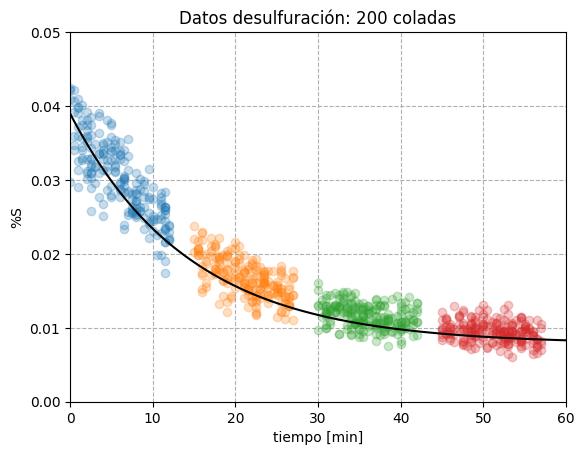

In [33]:
# visualización de los datos de proceso y solución E.D.
fig, ax = plt.subplots()

unique_samples = pd.unique(df["sample"])
for sample in (unique_samples):
    dfr = df[df["sample"] == sample]
    ax.plot(dfr["t"], dfr["S"], ls='', marker='o', alpha=0.25)
ax.set(
    xlabel='tiempo [min]',
    ylabel='%S',
    xlim = (0, 60),
    ylim = (0, 0.05),
    title = f"Datos desulfuración: {nHeats} coladas"
)

ax.plot(sol.t, sol.y[0], ls='-', c='k')


ax.grid(ls='--')
plt.show()

## 5.3 Referencias

[Secondary Steelmaking: Principles and Applications (2000)](https://doi.org/10.1201/9781420042313)  
GHOSH, Ahindra.
CRC Press.


Documentación scipy:

[scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

[scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)